In [2]:
from azureml.core import Workspace, Datastore

# load your workspace
ws = Workspace.from_config()

# register the SQL server as a datastore (note 'username', not 'user_name')
sql_ds = Datastore.register_azure_sql_database(
    workspace=ws,
    datastore_name="clv_sql_ds",                   
    server_name="cs5165-server.database.windows.net",
    database_name="cs5165-database",
    username="prestonisawesome",
    password="Password123!",
    port=1433,
    driver="{ODBC Driver 17 for SQL Server}"
)

print(f"Datastore registered: {sql_ds.name}")



TypeError: _DatastoreClient.register_azure_sql_database() got an unexpected keyword argument 'port'

In [3]:
from azureml.core import Workspace, Datastore

ws = Workspace.from_config()

sql_ds = Datastore.register_azure_sql_database(
    workspace=ws,
    datastore_name="clv_sql_ds",
    server_name="cs5165-server.database.windows.net",
    database_name="cs5165-database",
    username="prestonisawesome",
    password="Password123!",
    description="Datastore for CLV SQL tables"
)

print(f"Datastore registered: {sql_ds.name}")


TypeError: _DatastoreClient.register_azure_sql_database() got an unexpected keyword argument 'description'

In [4]:
!pip install pyodbc pandas --quiet



In [5]:
import pyodbc
import pandas as pd
from azureml.core import Workspace

# 1) Connect to your workspace
ws = Workspace.from_config()

# 2) Build your ODBC connection
conn_str = (
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=cs5165-server.database.windows.net,1433;"
    "DATABASE=cs5165-database;"
    "UID=prestonisawesome;"
    "PWD=Password123!;"
    "Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;"
)
cnxn = pyodbc.connect(conn_str)

# 3) Load each table
df_households   = pd.read_sql("SELECT * FROM dbo.[400_households];",   cnxn)
df_products     = pd.read_sql("SELECT * FROM dbo.[400_products];",     cnxn)
df_transactions = pd.read_sql("SELECT * FROM dbo.[400_transactions];", cnxn)

# 4) Quick sanity checks
print("Households:",   df_households.shape)
print("Products:",     df_products.shape)
print("Transactions:", df_transactions.shape)

df_households.head(3), df_products.head(3), df_transactions.head(3)


/tmp/ipykernel_29279/707597265.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_households   = pd.read_sql("SELECT * FROM dbo.[400_households];",   cnxn)
/tmp/ipykernel_29279/707597265.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_products     = pd.read_sql("SELECT * FROM dbo.[400_products];",     cnxn)
/tmp/ipykernel_29279/707597265.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_transactions = pd.read_sql("SELECT * FROM dbo.[400_transactions];", cnxn)


Households: (400, 9)
Products: (67284, 5)
Transactions: (922008, 9)


(   HSHD_NUM  L                                          AGE_RANGE  MARITAL  \
 0        10  Y  45-54                                         ...  Single    
 1        29  Y  55-64                                         ...  Married   
 2        53  Y  55-64                                         ...  Married   
 
                                         INCOME_RANGE  HOMEOWNER  \
 0  35-49K                                        ...  Homeowner   
 1  100-150K                                      ...  Homeowner   
 2  50-74K                                        ...  Homeowner   
 
     HSHD_COMPOSITION                                            HH_SIZE  \
 0  1 Adult            1                                             ...   
 1  2 Adults and Kids  3                                             ...   
 2  2 Adults and Kids  3                                             ...   
 
   CHILDREN  
 0     null  
 1        1  
 2        1  ,
    PRODUCT_NUM                  DEPARTMENT  

In [6]:

# 1) Quick schema and null checks
print("=== HOUSEHOLDS ===")
df_households.info()
print("\nNulls per column:")
print(df_households.isnull().sum())

print("\n=== PRODUCTS ===")
df_products.info()
print("\nNulls per column:")
print(df_products.isnull().sum())

print("\n=== TRANSACTIONS ===")
df_transactions.info()
print("\nNulls per column:")
print(df_transactions.isnull().sum())

# 2) Descriptive statistics
print("\n--- Spend Summary ---")
print(df_transactions["SPEND"].describe())

# 3) Distribution of household sizes (example)
print("\n--- Household Size Value Counts ---")
print(df_households["HH_SIZE"].value_counts())

# 4) Peek at top 5 spenders by household
spend_per_hh = (
    df_transactions
    .groupby("HSHD_NUM")["SPEND"]
    .sum()
    .sort_values(ascending=False)
)
print("\n--- Top 5 Households by Total Spend ---")
print(spend_per_hh.head(5))


=== HOUSEHOLDS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   HSHD_NUM          400 non-null    int64 
 1   L                 400 non-null    object
 2   AGE_RANGE         400 non-null    object
 3   MARITAL           400 non-null    object
 4   INCOME_RANGE      400 non-null    object
 5   HOMEOWNER         400 non-null    object
 6   HSHD_COMPOSITION  400 non-null    object
 7   HH_SIZE           400 non-null    object
 8   CHILDREN          400 non-null    object
dtypes: int64(1), object(8)
memory usage: 28.2+ KB

Nulls per column:
HSHD_NUM            0
L                   0
AGE_RANGE           0
MARITAL             0
INCOME_RANGE        0
HOMEOWNER           0
HSHD_COMPOSITION    0
HH_SIZE             0
CHILDREN            0
dtype: int64

=== PRODUCTS ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67284 entries, 0 to 67

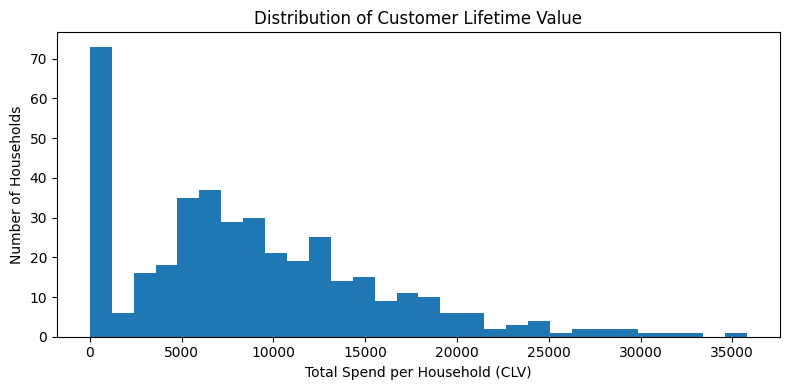

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# PURCHASE_DATE  datetime
df_transactions['PURCHASE_DATE'] = pd.to_datetime(df_transactions['PURCHASE_DATE'])

# Clean HH_SIZE  numeric
hs = df_households['HH_SIZE'].astype(str).str.strip()
df_households['HH_SIZE_NUM'] = (
    hs
     .replace({'null': '0', '': '0', '5+': '5'})  # null/empty → 0, "5+" → 5
     .astype(float)
)

# Clean CHILDREN → integer
ch = df_households['CHILDREN'].astype(str).str.strip().str.replace('+', '', regex=False)
df_households['CHILDREN_NUM'] = (
    ch
      .replace({'null': '0', '': '0'}) 
      .astype(int)
)

# Recompute CLV and re‐plot
clv = (
    df_transactions
     .groupby('HSHD_NUM')['SPEND'].sum()
     .reset_index(name='CLV')
     .merge(
         df_households[['HSHD_NUM', 'HH_SIZE_NUM', 'CHILDREN_NUM']],
         on='HSHD_NUM', how='left'
     )
)

plt.figure(figsize=(8,4))
plt.hist(clv['CLV'], bins=30)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('Total Spend per Household (CLV)')
plt.ylabel('Number of Households')
plt.tight_layout()
plt.show()



In [16]:
# Drop returns or zero‐dollar rows
df_transactions = df_transactions[df_transactions['SPEND'] > 0].copy()
print("Transactions after filtering:", df_transactions.shape)


Transactions after filtering: (917615, 9)


In [18]:
import pandas as pd
last_date     = df_transactions['PURCHASE_DATE'].max()
snapshot_date = last_date + pd.Timedelta(days=1)

# Aggregate purchases
agg = df_transactions.groupby('HSHD_NUM').agg(
    first_purchase  = ('PURCHASE_DATE','min'),
    last_purchase   = ('PURCHASE_DATE','max'),
    frequency       = ('PURCHASE_DATE','count'),
    monetary_value  = ('SPEND','mean')
).reset_index()

# Compute recency (time between first & last) and T (time between first & snapshot)
agg['recency'] = (agg['last_purchase'] - agg['first_purchase']).dt.days
agg['T']       = (snapshot_date             - agg['first_purchase']).dt.days

# RFM DataFrame
rfm = agg[['HSHD_NUM','frequency','recency','T','monetary_value']]


print("RFM shape:", rfm.shape)
print("\nNull counts per column:")
print(rfm.isnull().sum())
print("\nRecency ≤ T for all households?")
print((rfm['recency'] <= rfm['T']).all())

print("\nRFM summary:")
print(rfm.describe())



RFM shape: (400, 5)

Null counts per column:
HSHD_NUM          0
frequency         0
recency           0
T                 0
monetary_value    0
dtype: int64

Recency ≤ T for all households?
True

RFM summary:
          HSHD_NUM    frequency     recency           T  monetary_value
count   400.000000   400.000000  400.000000  400.000000      400.000000
mean   2469.137500  2294.037500  614.902500  681.682500        3.961095
std    1424.312238  1773.950353  235.780957  121.473665        1.327674
min      10.000000     1.000000    0.000000   24.000000        1.000000
25%    1268.750000  1150.250000  709.000000  722.000000        3.279485
50%    2413.000000  2066.000000  723.000000  728.000000        3.725050
75%    3710.500000  3274.000000  727.000000  729.250000        4.379560
max    4989.000000  9979.000000  729.000000  730.000000       16.980000


In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Prepare X (features) and y (target = total CLV)
clv_total = (
    df_transactions
      .groupby('HSHD_NUM')['SPEND']
      .sum()
      .rename('CLV')
)
# join with rfm on HSHD_NUM
rfm_model = rfm.set_index('HSHD_NUM').join(clv_total).dropna()

X = rfm_model[['frequency','recency','T','monetary_value']]
y = rfm_model['CLV']

# Initialize the model
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
)

# Fit & evaluate via OOB score + 5-fold CV
rf.fit(X, y)
print(f"OOB R² score: {rf.oob_score_:.3f}")

cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2', n_jobs=-1)
print(f"5-fold CV R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Feature importances
import pandas as pd
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(fi)



OOB R² score: 0.971
5-fold CV R²: 0.968 ± 0.015

Feature importances:
frequency         0.924454
monetary_value    0.073472
recency           0.001619
T                 0.000455
dtype: float64
